In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [30]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [31]:
len(words)

32033

In [32]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [33]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [34]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 30), generator=g) * 0.01
W1 = torch.randn((90, 250), generator=g) * 0.01
b1 = torch.randn(250, generator=g) * 0.01
W2 = torch.randn((250, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]
# ans for q-2 intialising uniform parameters

In [35]:
sum(p.nelement() for p in parameters) # number of parameters in total

30337

In [36]:
# ans for 2-part
 #the uniform cross-entropy loss would be:Loss=log(27)

In [37]:
for p in parameters:
  p.requires_grad = True

In [38]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [39]:
lri = []
lossi = []
stepi = []

In [40]:
for i in range(8000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  #print(Xtr.shape)
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  #print(emb.shape)
  h = torch.tanh(emb.view(-1, 90) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

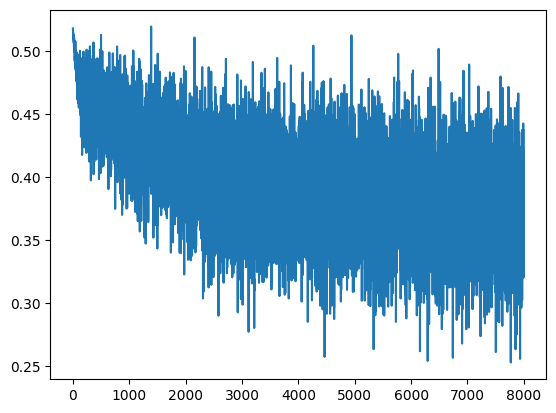

In [41]:
plt.plot(stepi, lossi)

In [42]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 90) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss
#loss much close to 2.2

tensor(2.3688, grad_fn=<NllLossBackward0>)

In [43]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 90) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3652, grad_fn=<NllLossBackward0>)

In [44]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 90) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.3669, grad_fn=<NllLossBackward0>)

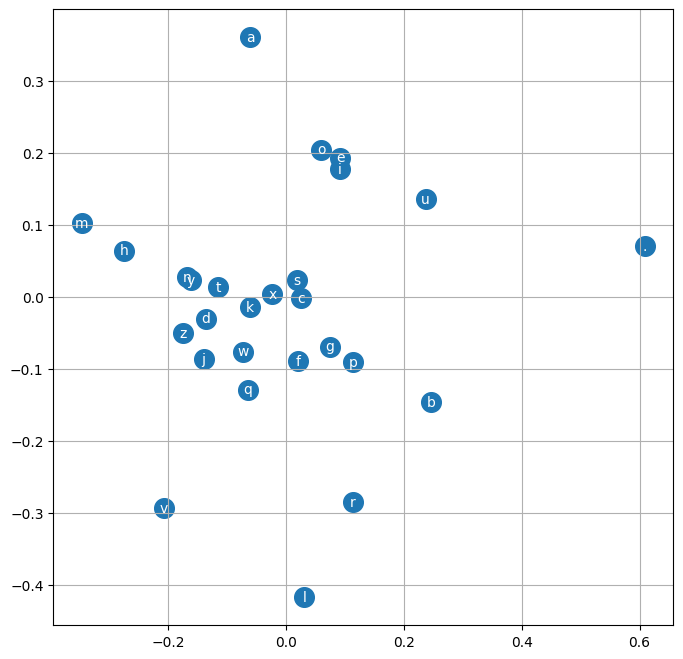

In [45]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [46]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mria.
kmyan.
reel.
ndhayla.
rethastendrlen.
adered.
elii.
shi.
jelleielayan.
aarlelynioh.
karin.
shubergahiries.
kin.
reellionn.
pucanu.
zeynder.
yahul.
ehs.
kay.
mistoyan.


In [47]:
# using batchnorm (q-5)
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set a random generator for reproducibility
g = torch.Generator().manual_seed(42)

# Initialize parameters
C = torch.randn((27, 30), generator=g) * 0.01
W1 = torch.randn((90, 250), generator=g) * 0.01
b1 = torch.randn(250, generator=g) * 0.01
W2 = torch.randn((250, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# Learning rates and tracking
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri, lossi, stepi = [], [], []

# Initialize BatchNorm
bn1 = nn.BatchNorm1d(250, affine=True)
bn1.running_mean = torch.zeros(250)
bn1.running_var = torch.ones(250)

# Training loop with mini-batch gradient descent
for i in range(8000):
    # Mini-batch construction
    ix = torch.randint(0, 1000, (32,))  # Assuming a dataset size of 1000
    Xtr = torch.randint(0, 27, (1000, 3))  # Example input (batch_size=1000, sequence_length=3)
    Ytr = torch.randint(0, 27, (1000,))    # Example labels

    # Forward pass
    emb = C[Xtr[ix]]  # (32, 3, 30)
    h = torch.tanh(emb.view(-1, 90) @ W1 + b1)  # (32, 250)
    h = bn1(h)  # Apply BatchNorm
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = lrs[i % 1000] if i < 1000 else 0.01  # Variable learning rate for the first 1000 iterations
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

# Function to fold BatchNorm into Linear layers
def fold_batchnorm(linear_W, linear_b, bn_layer):
    gamma = bn_layer.weight
    beta = bn_layer.bias
    running_mean = bn_layer.running_mean
    running_var = bn_layer.running_var
    eps = bn_layer.eps

    scale = gamma / torch.sqrt(running_var + eps)
    W2 = linear_W * scale.unsqueeze(0)
    b2 = linear_b * scale + (beta - scale * running_mean)

    return W2, b2

# Fold BatchNorm into the linear layer's weights and biases
W1_folded, b1_folded = fold_batchnorm(W1, b1, bn1)

# Verification: Forward pass with the folded weights
emb = C[Xtr[ix]]  # Reuse the last batch of input
h_folded = torch.tanh(emb.view(-1, 90) @ W1_folded + b1_folded)  # (32, 250)
logits_folded = h_folded @ W2 + b2  # (32, 27)

# Compare the original and folded outputs
print("Original loss:", loss.item())
print("Folded loss:", F.cross_entropy(logits_folded, Ytr[ix]).item())


Original loss: 3.2390129566192627
Folded loss: 3.193441867828369
